In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
import json
import matplotlib.patches as patches
from mpl_toolkits import mplot3d
from matplotlib import colors
import os

In [8]:
def plot(points_to_plot, x_lim, y_lim):
    # PLOT THE IMAGE
    dpi = 100       # Image resolution

    fig, ax = plt.subplots(figsize=(30,30), dpi=dpi)

    ax = plt.axes(projection ='3d')
    ax.scatter(points_to_plot[:, 0], points_to_plot[:, 1], points_to_plot[:, 2], s=0.2, c=points_to_plot[:, 3])

#     ax.view_init(30, 180)
    ax.view_init(0, 180)

    ax.set_xlabel('$X$', fontsize=20)
    ax.set_ylabel('$Y$', fontsize=20)
    ax.set_zlabel('$Z$', fontsize=20)

    ax.axis('scaled')

    ax.xaxis.set_visible(True)  # Do not draw axis tick marks
    ax.yaxis.set_visible(True)  # Do not draw axis tick marks
    ax.zaxis.set_visible(True)  # Do not draw axis tick marks
    ax.grid(False)

    plt.xlim(x_lim)  
    plt.ylim(y_lim)

    plt.show()

In [9]:
### Config ###
date = '2019_02_27'
seq = '0078'
frame_id = 325
DISTORTED = True


In [10]:
BASE = "C:/Users/meiqt/Repos/dataset/cadcd"
# BASE = "C:/Users/meiqt/Desktop/data"
OUTPUT = 'output/'

if DISTORTED:
  path_type = 'raw'
else:
  path_type = 'labeled'

lidar_path = os.path.join(BASE, date + '/' + seq + "/" + path_type + "/lidar_points/data/" + format(frame_id, '010') + ".bin")
# lidar_path = os.path.join(BASE, format(frame_id, '010') + ".bin")

In [11]:
# Cropping
x_range = [-50, 50] 
y_range = [-50, 50]

# snow_cropping_x_range = x_range
snow_cropping_x_range = [-10, 10]
# snow_cropping_y_range = y_range
snow_cropping_y_range = [-9, 5]

z_min = -1
intensity_max = 5

snow_condition_override = False


In [12]:
lidar_data = np.fromfile(lidar_path, dtype= np.float32).reshape((-1, 4))

n_points = lidar_data.shape[0]

In [13]:
snow_points = []
removed_points = []
trimmed_lidar_data = []
for i in range(n_points):
    lidar_x, lidar_y, lidar_z, lidar_intensity = lidar_data[i] 
    
    snow_condition = lidar_z > z_min and lidar_intensity < intensity_max and \
                        snow_cropping_y_range[0] < lidar_y < snow_cropping_y_range[1]
    
    if  x_range[0] < lidar_x < x_range[1] and \
    y_range[0] < lidar_y < y_range[1]:
        trimmed_lidar_data.append([lidar_x, lidar_y, lidar_z, lidar_intensity])
    
        if (snow_condition or snow_condition_override): 
            snow_points.append([lidar_x, lidar_y, lidar_z, lidar_intensity])
        else:
            removed_points.append([lidar_x, lidar_y, lidar_z, lidar_intensity])
    else:
        removed_points.append([lidar_x, lidar_y, lidar_z, lidar_intensity])
        
snow_points = np.asarray(snow_points)
trimmed_lidar_data = np.asarray(trimmed_lidar_data)
removed_points = np.asarray(removed_points)

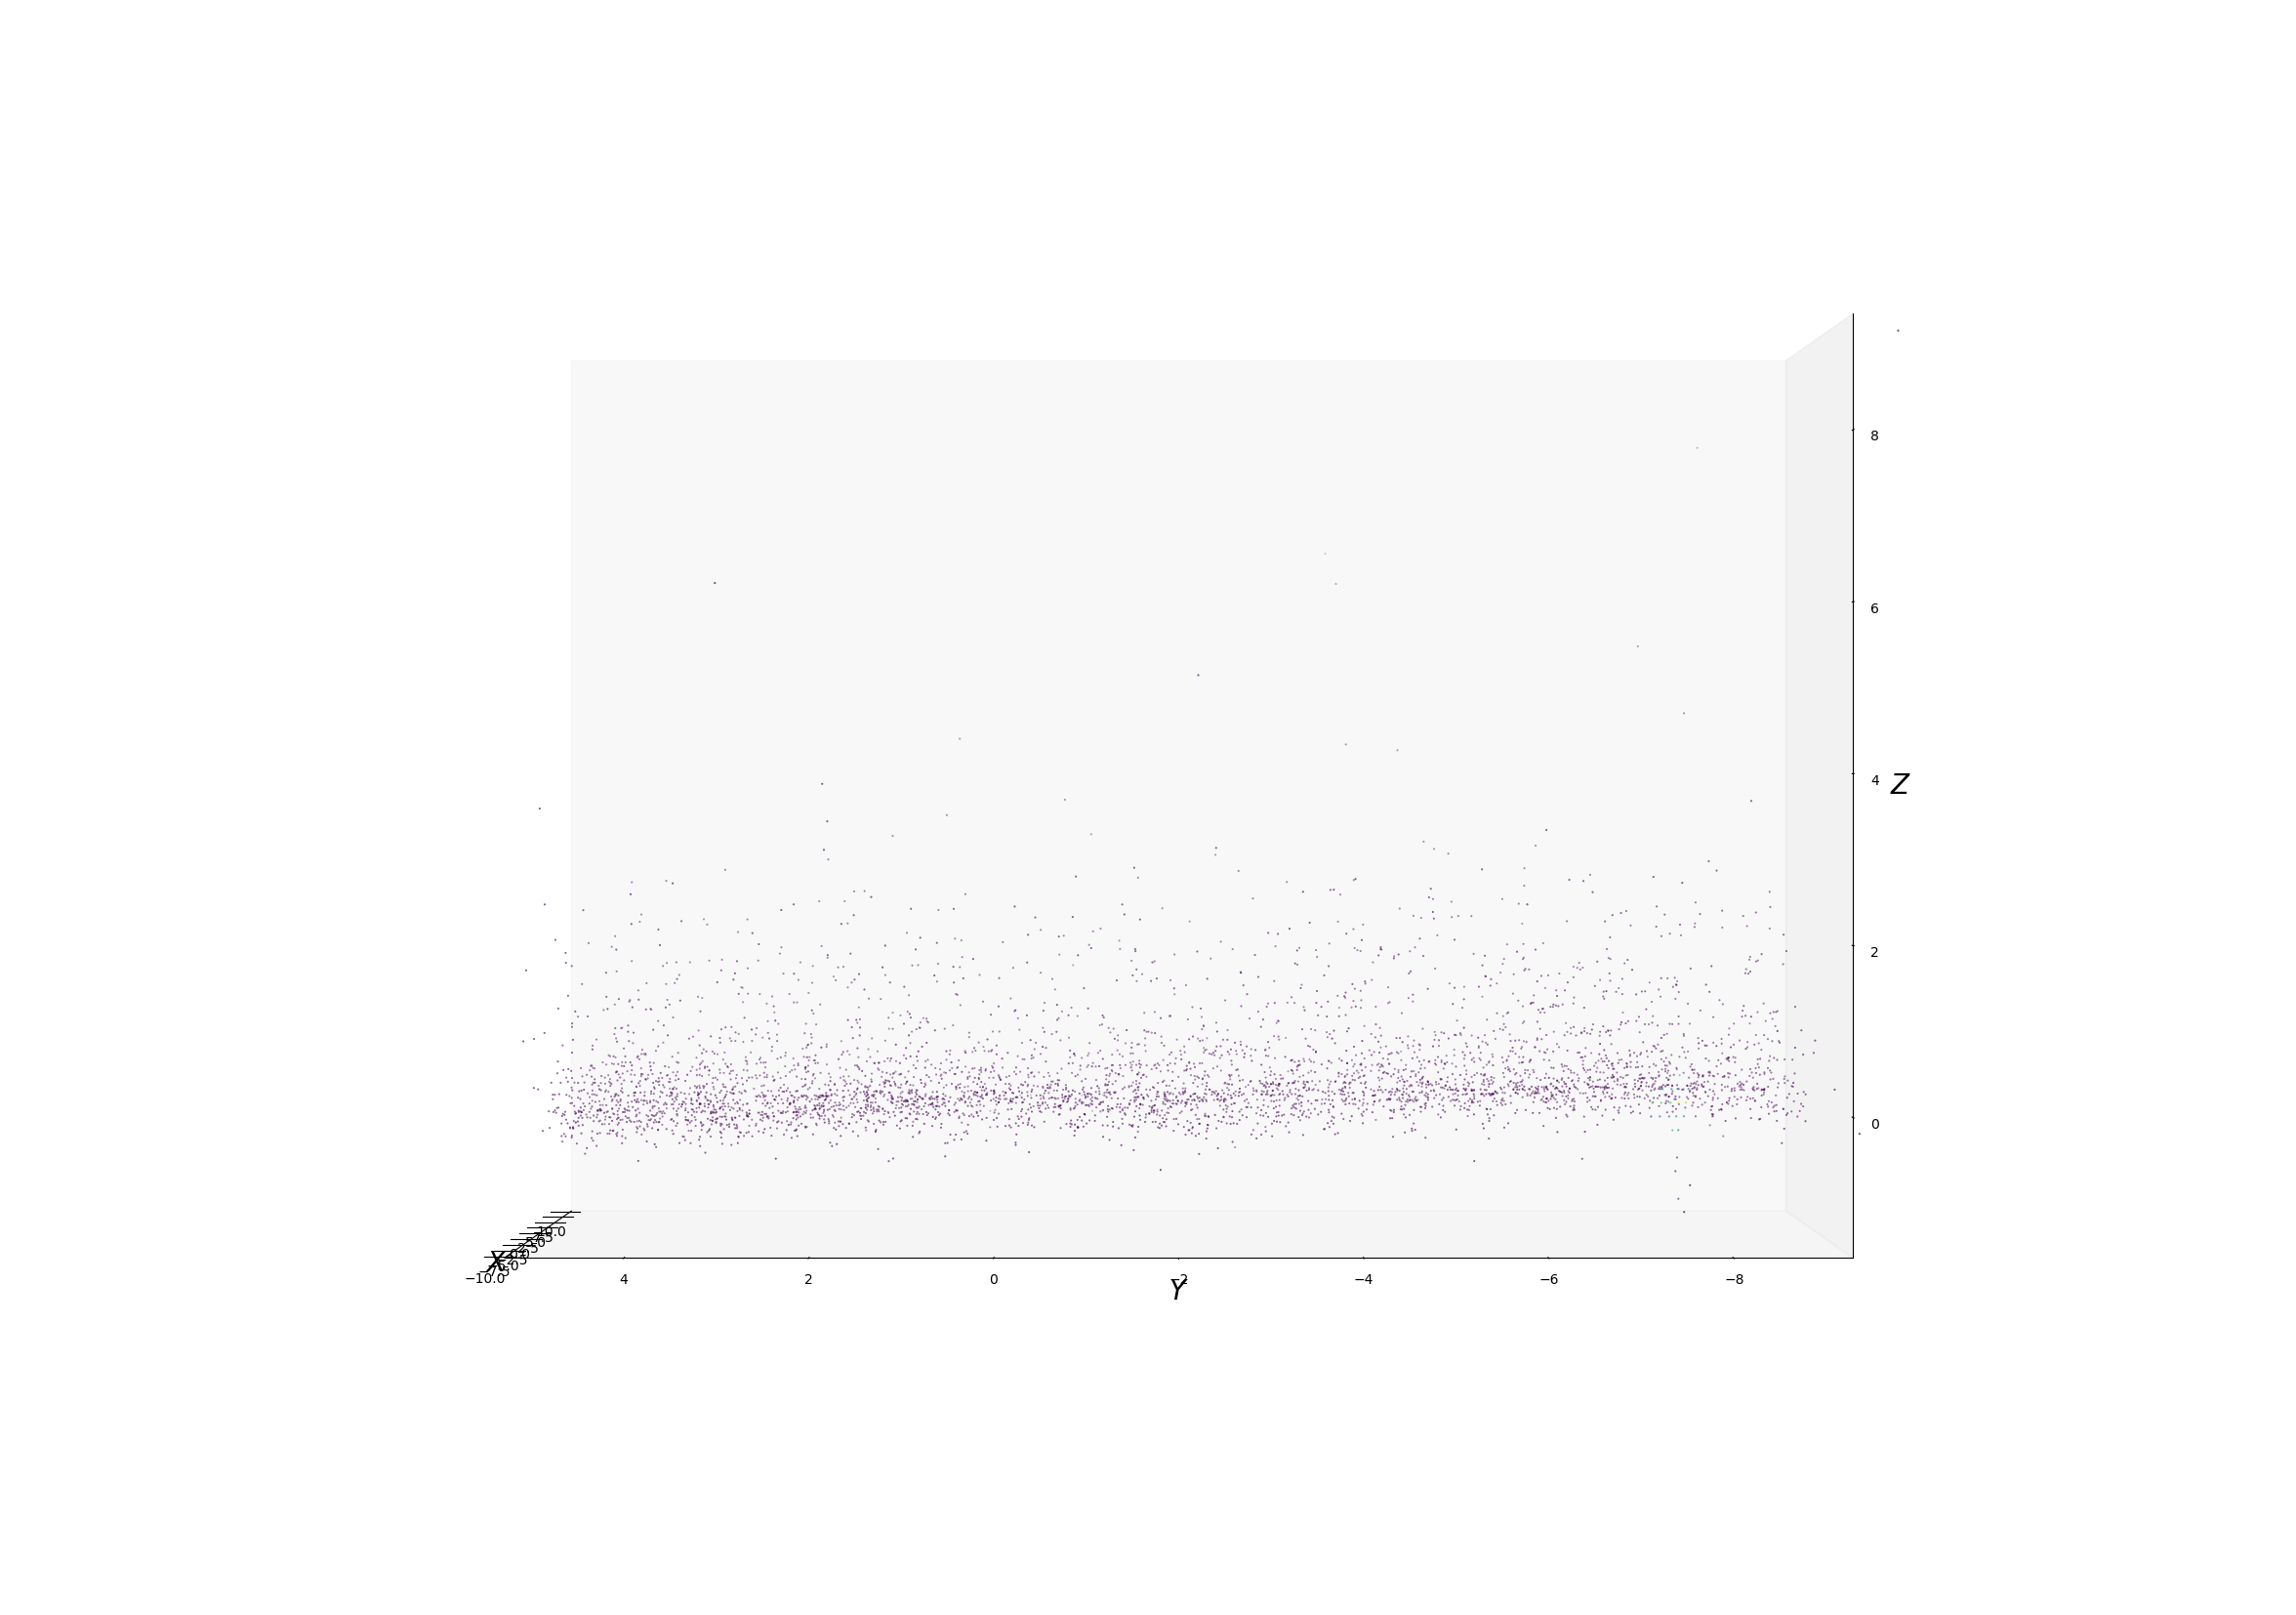

In [14]:
plot(snow_points, x_lim=snow_cropping_x_range, y_lim=snow_cropping_y_range)

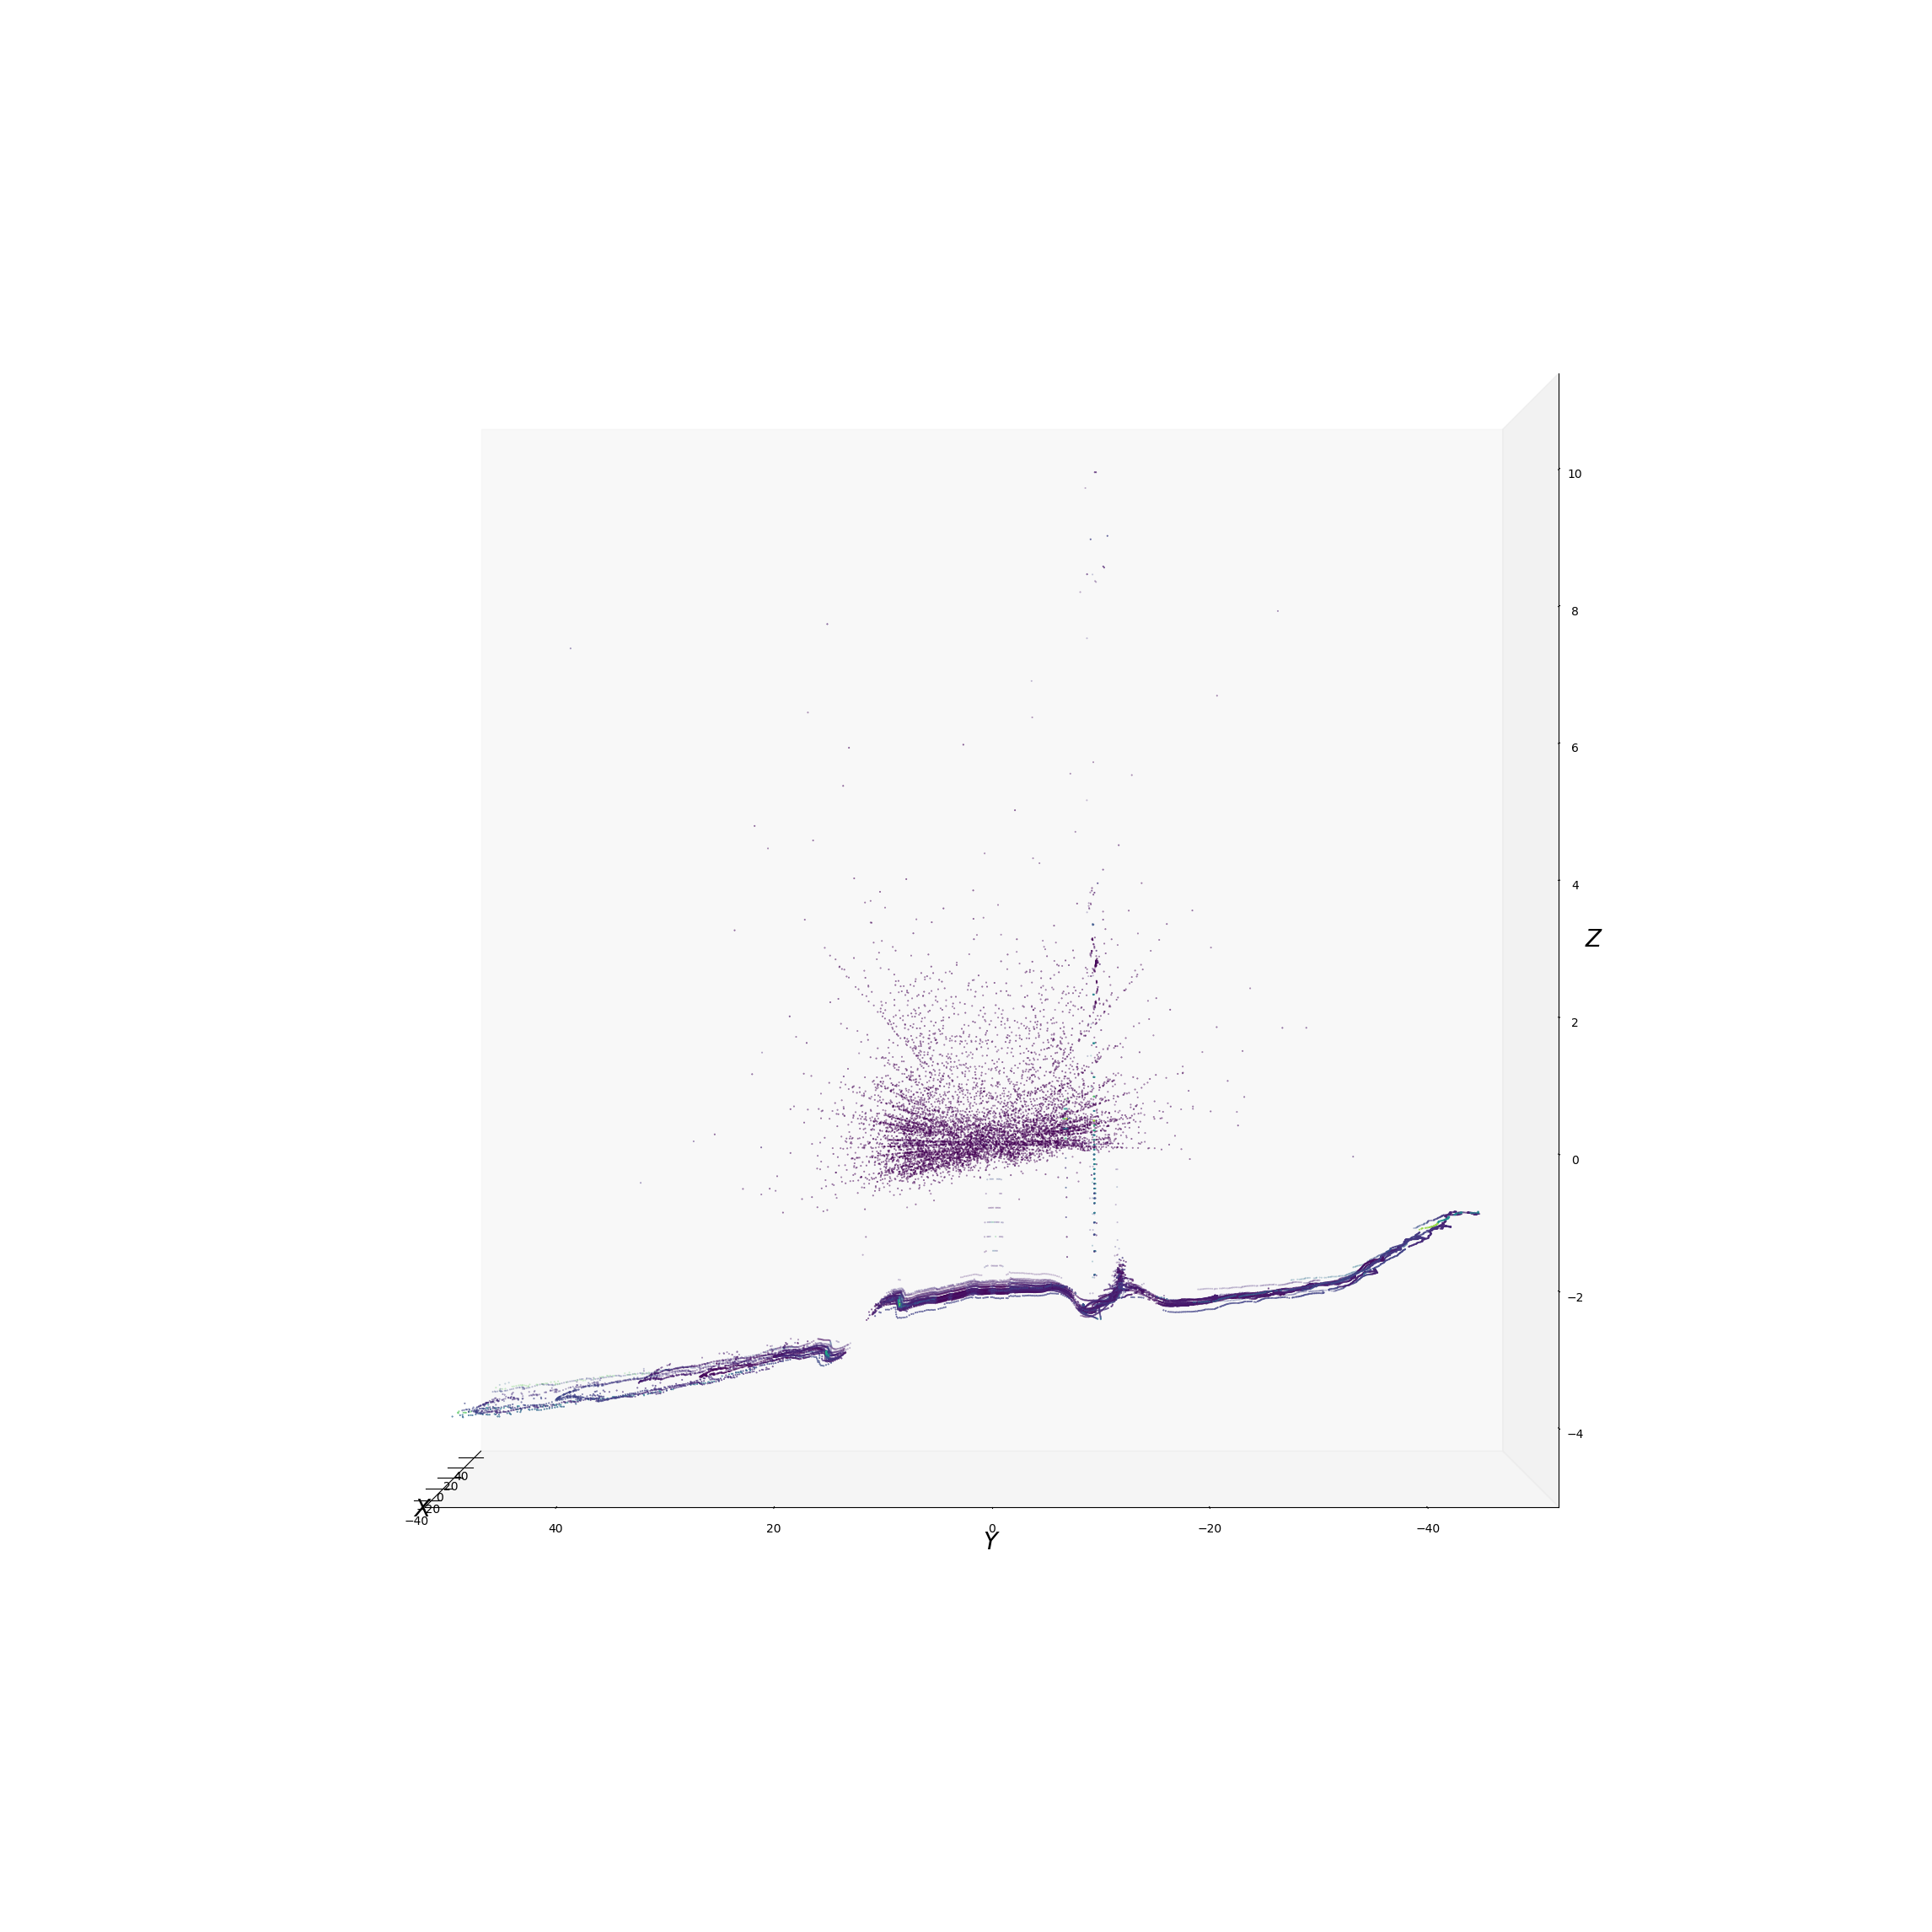

In [15]:
plot(trimmed_lidar_data, x_range, y_range)

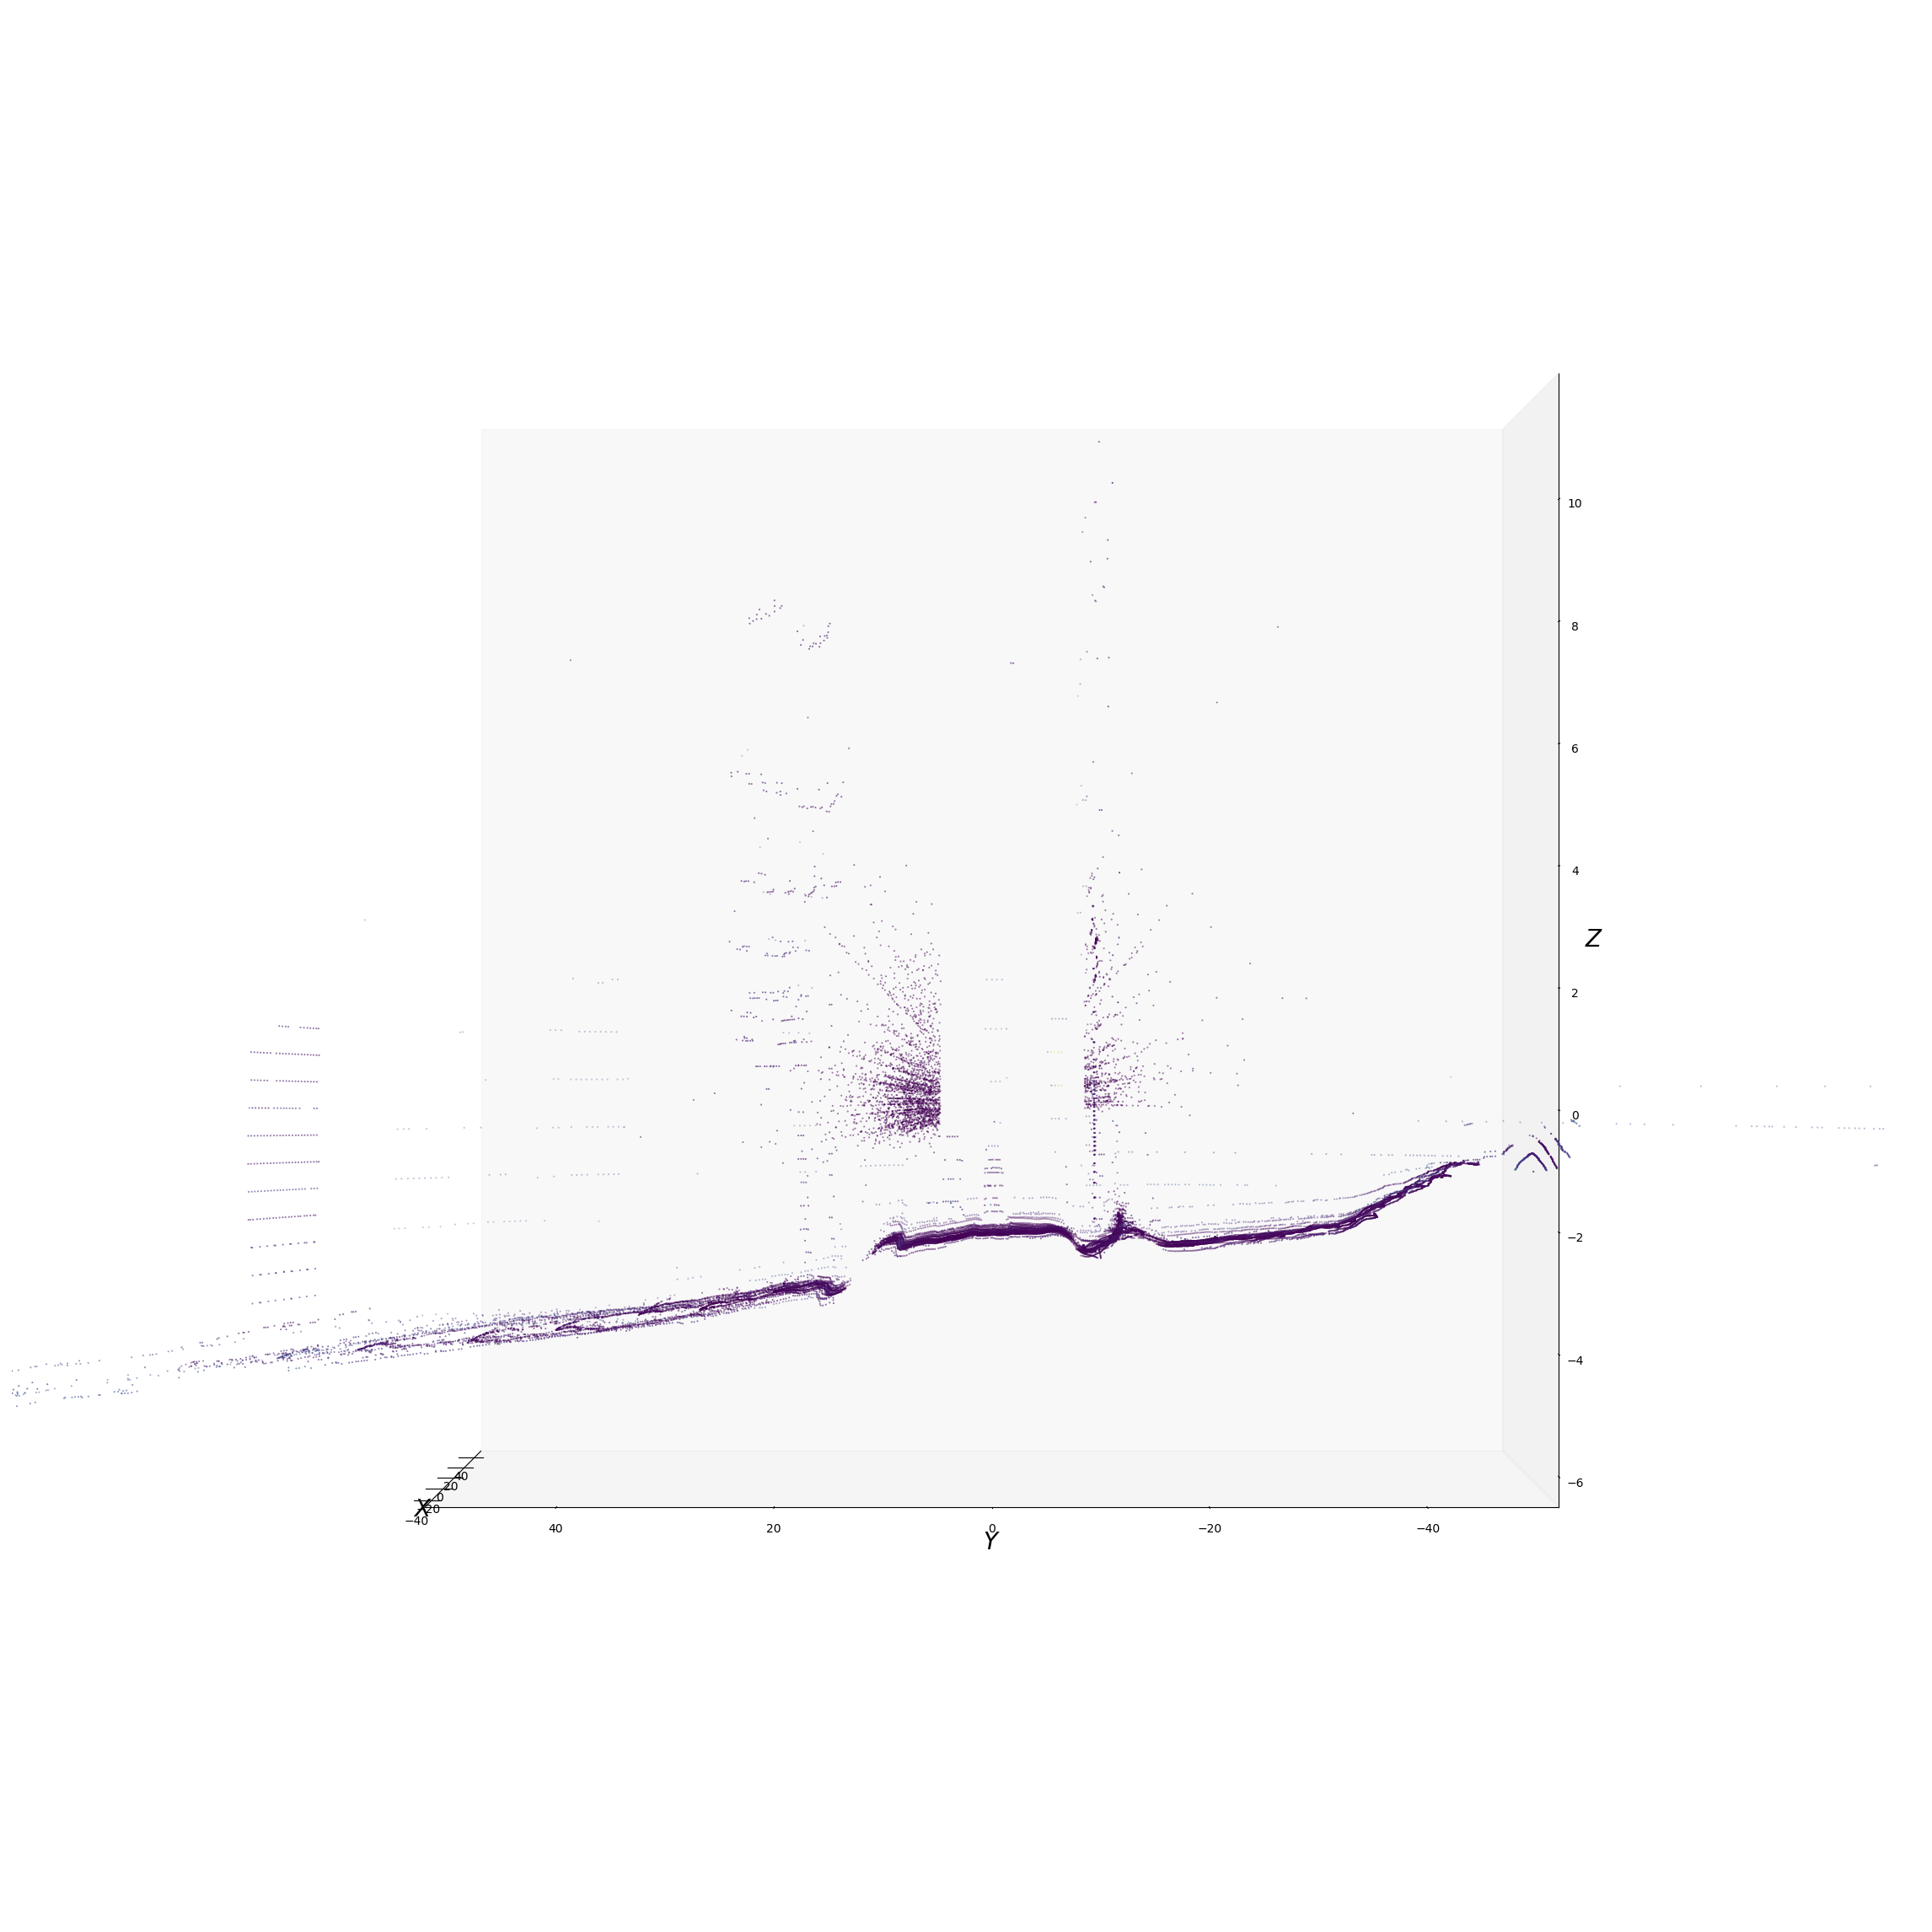

In [16]:
plot(removed_points, x_range, y_range)

In [81]:
distance_distribution = []
intensity_distribution = []
distance_per_intensity = {}
n_bins = snow_points.shape[0]

for i in range(n_bins):
    distance = np.sqrt(snow_points[i, 0]**2 + snow_points[i, 1]**2 + snow_points[i, 2]**2)
    intensity = snow_points[i, 3]
    
    distance_distribution.append(distance) 
    intensity_distribution.append(intensity)
     
    distances = distance_per_intensity.get(intensity, [])
    distances.append(distance)
    distance_per_intensity[intensity] = distances
    

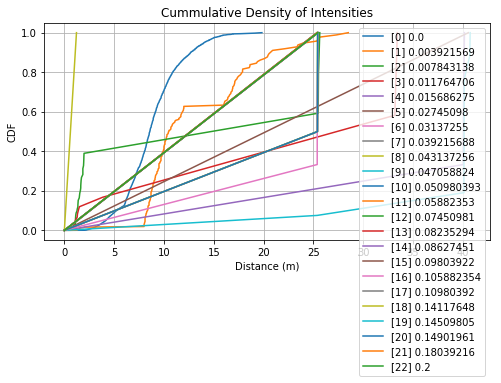

In [90]:
fig, ax = plt.subplots(figsize=(8, 4))

labels = []
for i, intensity in enumerate(sorted(list(distance_per_intensity.keys()))[:]):
    x = [0]
    x += sorted(distance_per_intensity[intensity])
    sum = np.sum(x)
    y = np.cumsum(x) / sum
    ax.plot(x, y)
#     n, bins, patches = ax.hist(distance_per_intensity[i], bins=len(distance_per_intensity[i]), density=True, histtype='step', cumulative=True, label='Empirical')
    labels.append("["+ str(i) +"] " + str(intensity))
    
plt.legend(labels)
ax.grid(True)
ax.set_title('Cummulative Density of Intensities')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('CDF')
plt.show()

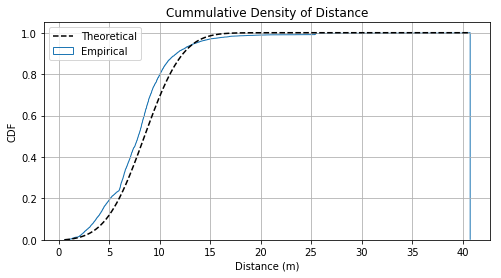

In [85]:
mu = 8.5
sigma = 3
    
fig, ax = plt.subplots(figsize=(8, 4))
n, bins, patches = ax.hist(distance_distribution, bins=n_bins, density=True, histtype='step', cumulative=True, label='Empirical')
ax.grid(True)

y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
    np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
y = y.cumsum()
y /= y[-1]

ax.plot(bins, y, 'k--', linewidth=1.5, label='Theoretical')
ax.grid(True)
ax.set_title('Cummulative Density of Distance')
ax.set_xlabel('Distance (m)')
ax.set_ylabel('CDF')
plt.legend(['Theoretical', 'Empirical'])
plt.show()
     